# MVP — xT Heatmap Analysis of U Cluj’s Defensive Performance (2024–2025 Season)

> **Note:** The official guide I drew inspiration from is the one developed and posted by *Soccermatics* ([read more](https://soccermatics.readthedocs.io/en/latest/gallery/lesson4/plot_ExpectedThreat.html)).

## Main Idea Behind This MVP

Building on that guide, I want to analyze the zones where U Cluj is most exposed to danger and understand how opponent activity during the regular season and playoffs impacts these areas.

Additionally, I’d like to identify patterns in the zones with the highest offensive activity. This will be measured by analyzing:

- **Types Passes:** The volume and direction of opponent's passes.  
- **Shots:** The location of shots and how well they convert into goals (xG).  
- **xT change:** How the expected threat (xT) value changes after a series of movements.  

By combining these analyses, I hope to create a comprehensive xT heatmap that provides insights into our team’s defensive vulnerabilities.


## Understanding the idea behind the Markov Chain, the backbone of the xT heatmap.

Import the necessary libraries:

- **pandas**: Used for working with DataFrames and simplifying data manipulation (in this case, handling the Wyscout CSV data provided by the bootcamp mentors).  
- **numpy**: Provides tools for array/matrix operations and linear algebra functions.  
- **matplotlib**: Essential for creating plots and adjusting their coloring and appearance.  
- **warnings**: Included to suppress specific pandas warnings in certain cases, as suggested in the guide.  
- **mplsoccer**: Used to plot the football pitch and map events onto it, following the metric system used by Wyscout.  
- **scipy.stats.binned_statistic_2d**: Applied to divide the pitch into zones and compute aggregated statistics within each zone.  
- **itertools.product**: Used to mask zones without activity by setting them to zero, avoiding `NaN` values.  
- **ast**: Helpful for parsing `type.secondary` column values when filtering and analyzing different types of passes.  


In [195]:
#importing necessary libraries
import pandas as pd
import numpy as np
# plotting
import matplotlib.pyplot as plt
import warnings
#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d
from itertools import product
import ast
#surpressing some warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

I referred to a video from _Soccermatics_ that explained the concept behind xT modeling, how it is derived mathematically, and provided an example of the required components and the expected results using Python ([read more](https://soccermatics.readthedocs.io/en/latest/gallery/lesson4/plot_MarkovChain.html)).

In [196]:
#Pass matrix
A = np.matrix([[0.25, 0.20, 0.1], [0.1, 0.25, 0.2],[0.1, 0.1, 0.25]])
#Goal vector
g = np.transpose(np.matrix([0.05, 0.15, 0.05]))

In [197]:
xT1 = np.linalg.solve(np.identity(3) - A,g)

print('Expected Threat')
print('Central, Box, Wing')
print(np.transpose(xT1))

Expected Threat
Central, Box, Wing
[[0.14991763 0.25205931 0.12026359]]


## Step-by-step application and adaptation of the guide

### 1. Getting the data in the right format:

- The main difference between this notebook and the guide provided by *Soccermatics* is that their data was in JSON format, while I worked with the CSV format instead.  
- To ensure this notebook runs without issues, make sure to have the Wyscout data in CSV format, place it in a folder named `datasets/`, and use the same file naming convention shown in the code below.

In [198]:
df1 = pd.read_csv("../datasets/Universitatea_Cluj_2024_2025_events.csv")

### 2. Filtering only the opponents’ movements:

- To better understand U Cluj’s defensive perspective, the main adjustment I applied to the data was filtering out *only the events of the opposing teams*. This was done as follows:
  - I searched through the CSV file for U Cluj’s `team.id`.
  - By specifying `df1["team.id"] != 60374` in the code below, I essentially told Python: *“give me all the teams’ events that are not from U Cluj.”*  
    As a result, only the opponents’ events remain, while U Cluj’s own events are excluded.  
  - This way, I focus on the opponents’ “attacking” events, but interpret the results from U Cluj’s perspective. Doing so highlights the zones where U Cluj’s defense is being exploited.

In [199]:
df = df1[df1["team.id"]!=60374]

### 3. Verifying the filtering and creating a lookup table

- To confirm that the filtering was applied correctly, I created a simple table of tuples in the format `(id, team_name)`.  
- This makes it easier to quickly check and look up which team each `team.id` corresponds to.

In [200]:
# Get a DataFrame with unique combinations of 'team.id' and 'team.name'
unique_teams = df[['team.id','team.name']].drop_duplicates()

# Print the resulting DataFrame
print(f"Unique teams found in the dataset:\n{unique_teams}")

Unique teams found in the dataset:
       team.id              team.name
0        11566        Rapid Bucureşti
1632     11564       Dinamo Bucureşti
3249     11565          FCS Bucureşti
4962     11611               CFR Cluj
6589     26233  Universitatea Craiova
16815    61242        Farul Constanţa
18717    11634               Botoşani
20506    11571                 Oţelul
22412    11663        Unirea Slobozia
24252    11886              Poli Iaşi
31182    60392            AS FC Buzău
32854    30827                  Sepsi
34527    60390            Petrolul 52
37838    30817               UTA Arad
39600    55427           Hermannstadt


### 4. Verifying top passes by type based on the `type.secondary` column values:

- The `type.secondary` column contains arrays of strings, where each string represents a “tag” assigned to that event for better classification and easier lookup.  
- I searched through this column to identify all pass types, since the guide later requires mapping actions related to *moving the ball*. Some of the pass names in my dataset did not exactly match the naming used in the guide.  
- To resolve this, I counted the frequency of each pass type and sorted them in descending order by frequency.

In [201]:

# First, convert the string representation of lists to actual lists

df['type.secondary'] = df['type.secondary'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Now, filter the DataFrame for rows where any word in the list contains '_pass'

filtered_passes = df[df['type.secondary'].apply(lambda x: any('_pass' in word for word in x))].copy()

# Flatten the lists to count the individual words
all_words = filtered_passes['type.secondary'].explode()

# Count the frequency of each word that contains "_pass"
pass_counts = all_words[all_words.str.contains('_pass', na=False)].value_counts()

#print results

print(pass_counts)

type.secondary
short_or_medium_pass    12686
forward_pass             5737
lateral_pass             4750
progressive_pass         2717
back_pass                2234
long_pass                2050
head_pass                1275
through_pass              152
hand_pass                 117
key_pass                   85
smart_pass                 50
Name: count, dtype: int64


### 5. Analyzing Ball-Moving Actions

The code I wrote below is basically a refined version of the guide’s example, but adapted to fit my dataset and the way I wanted to look at ball-moving events.


`Event Type Associations`

While going through the guide, I mapped their general event types to the equivalents I found in my dataset:

- **Simple pass** → `short_or_medium_pass`  
- **High pass** → either `long_pass` or `forward_pass`  
- **Head pass** → `head_pass`  
- **Smart pass** → `smart_pass`  
- **Cross** → `cross` (this one matched directly in my `type.secondary` column)  

`Expanding the Events`

I didn’t want to stop there and decided to add a few more pass types that felt important for my analysis:

- `forward_pass`  
- `progressive_pass`  
- `lateral_pass`  
- `back_pass`  
- `dribble` - this one was especially interesting because it shows up in my dataset but wasn’t included in the guide’s version.  

Why add these?  
- I noticed they appear quite often in the data, and I didn’t want to miss out on useful information.  
- Even if some overlap with other categories, including them explicitly gave me confidence I wasn’t overlooking edge cases.  
- Altogether, they helped me build a fuller picture of how opponents move the ball around against U Cluj.  

`The Movements Map`

One of the most exciting parts for me was creating the **Movements Map**. This visualization shows the starting locations of all ball-moving actions by U Cluj’s opponents from last season.

For me, as the one interpreting the results, the real value of this map is that it doesn’t just show where U Cluj is exposed (that part is already clear in the xT heatmap), but it also highlights *where those threats actually begin*. In other words, I can pinpoint the exact zones on the pitch where opponents start building their attacks. 

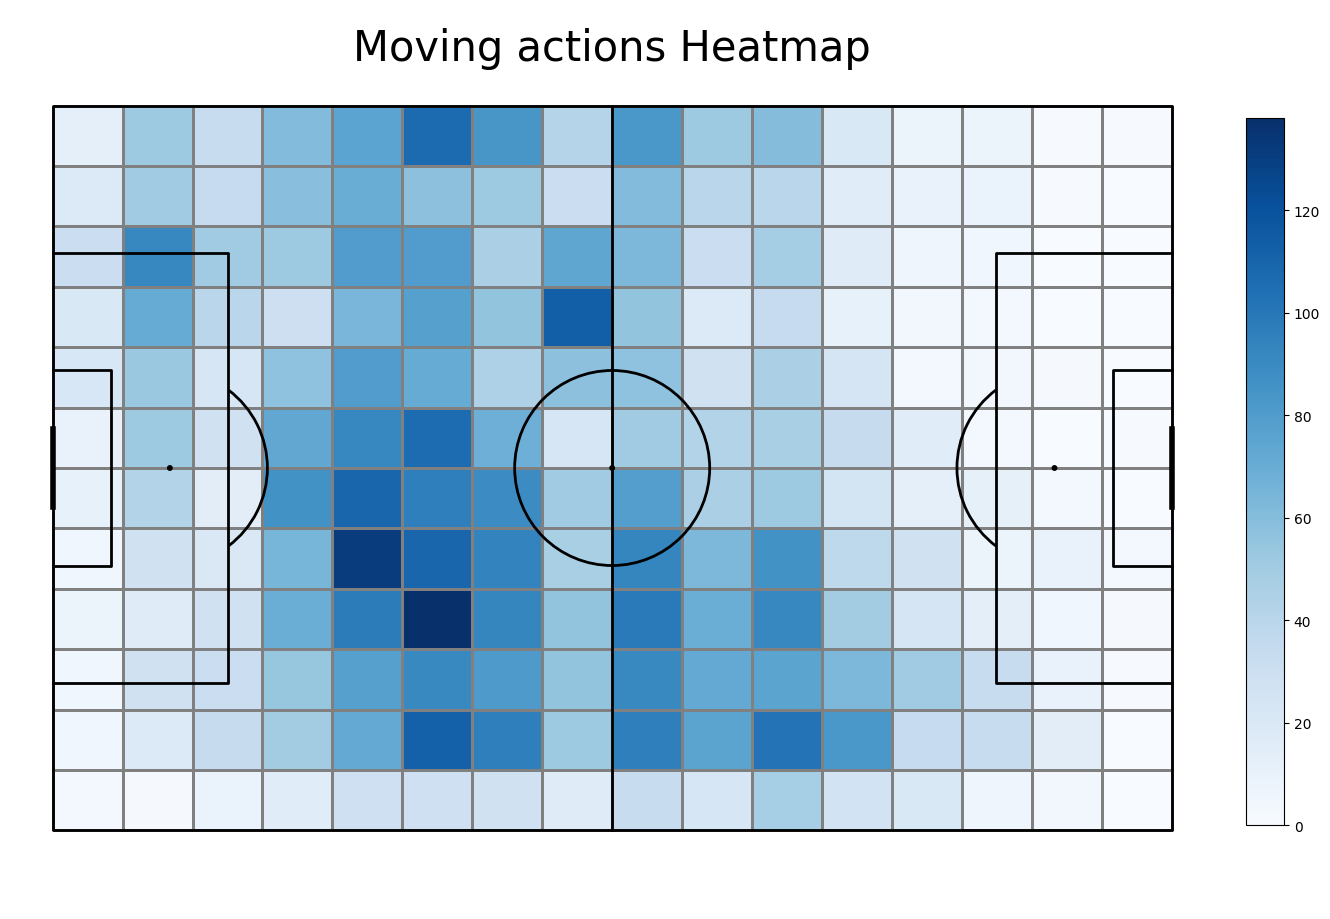

In [202]:
pass_types = ['short_or_medium_pass', 'long_pass', 'head_pass', 'smart_pass', 'cross','forward_pass','progressive_pass','lateral_pass','back_pass','dribble']

move_df = df.loc[
    (df['type.secondary'].apply(lambda x: any(item in x for item in pass_types))) &
    (df['pass.accurate'] == True)
]

# making sure the coordinates are in the right interval
move_df = move_df.loc[(((move_df["pass.endLocation.x"] != 0) & (move_df["pass.endLocation.y"] != 68)) & ((move_df["pass.endLocation.x"] != 105) & (move_df["pass.endLocation.y"] != 0)))]

# development of the heatmap
pitch = Pitch(line_color='black', pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
move = pitch.bin_statistic(move_df['location.x'], move_df['location.y'], statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Moving actions Heatmap', fontsize=30)
plt.show()

move_count = move["statistic"]

### 6. Shot Map

- Another key component for calculating xT, alongside the Movements Map, is the **Shot Heatmap**.  
- To build it, I selected all the `shot` events from my `type.primary` column. This column works like `type.secondary`, but it classifies each event with a single main tag.  
- From there, I created the heatmap based on the location of the player who took the shot.  

> **Note:** One possible improvement here would be to aggregate both xG and post-xG values to better evaluate each zone. However, since the purpose of this heatmap is to serve as just one *ingredient* in the xT heatmap, I decided to stick with plotting only the shot locations.


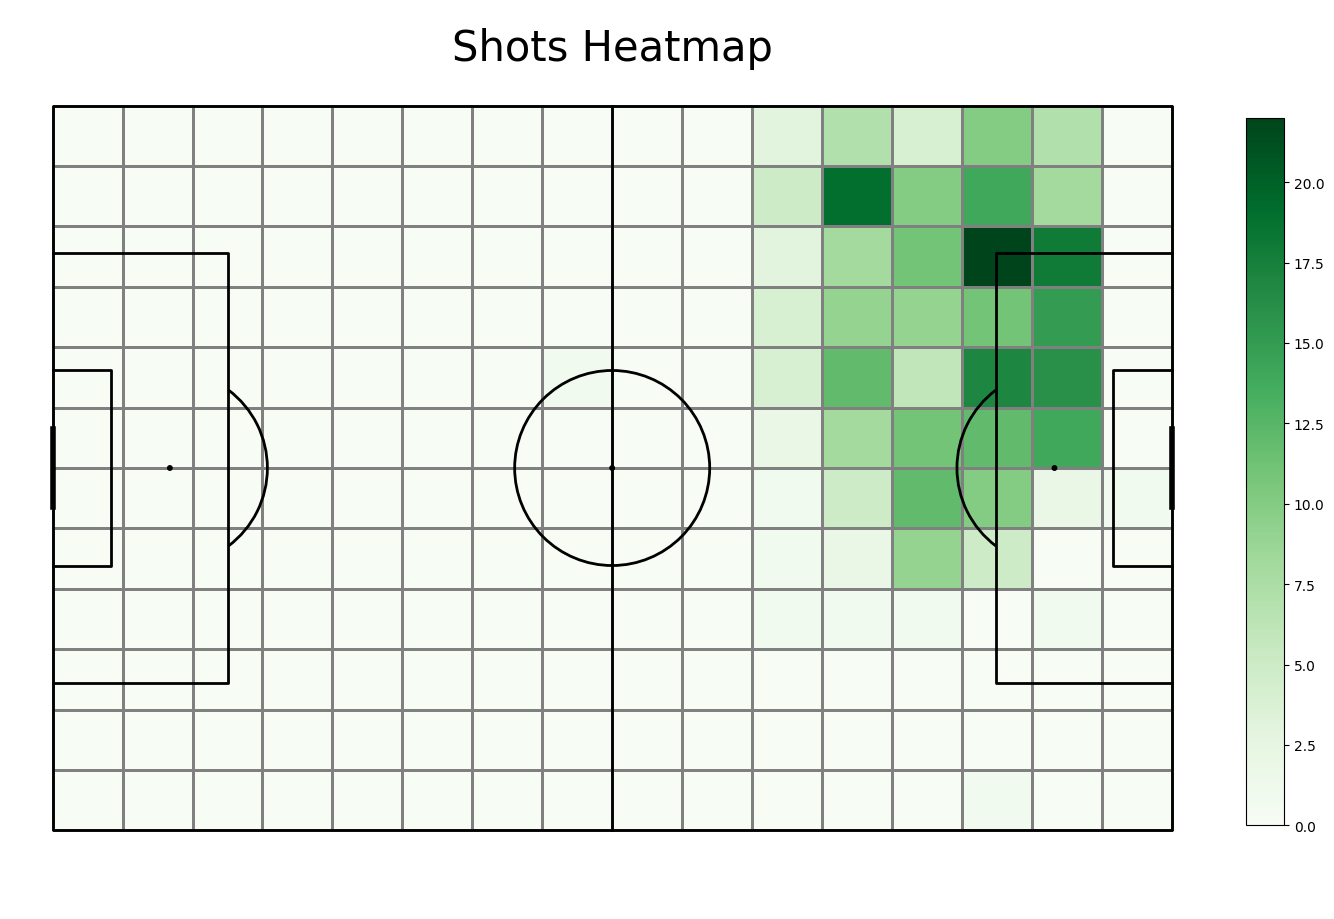

In [203]:
shot_df = df.loc[df['type.primary'] == "shot"]

shot = pitch.bin_statistic(shot_df["location.x"], shot_df["location.y"], statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots Heatmap', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

### 7. Goal Map

> *"A shot without a goal will never grace the history scroll."* ~ Bogdan, 2025  
- Joking, joking, moving on with the preparation for the xT Heatmap calculations. According to the guide, I also need to build the **Goal Heatmap**.  
- For my CSV data, I don’t have a direct event code that marks whether a shot was a goal or not. Instead, there’s a column called `shot.isGoal` (super inventive, right?), which contains `True/False` values for whether a shot ended up as a goal.  
- Using this, I filtered the Shot DataFrame to keep only the events where `shot.isGoal == True`, and then plotted their locations. These represent the “goal locations.”  

> **Note:** A possible improvement here would be to add aggregated analysis of how shots are taken by zones(ex: shot angles, shot placement within the goal, goalkeeper's position and similar metrics). This could also tie in nicely with the earlier idea of incorporating xG/postxG values.

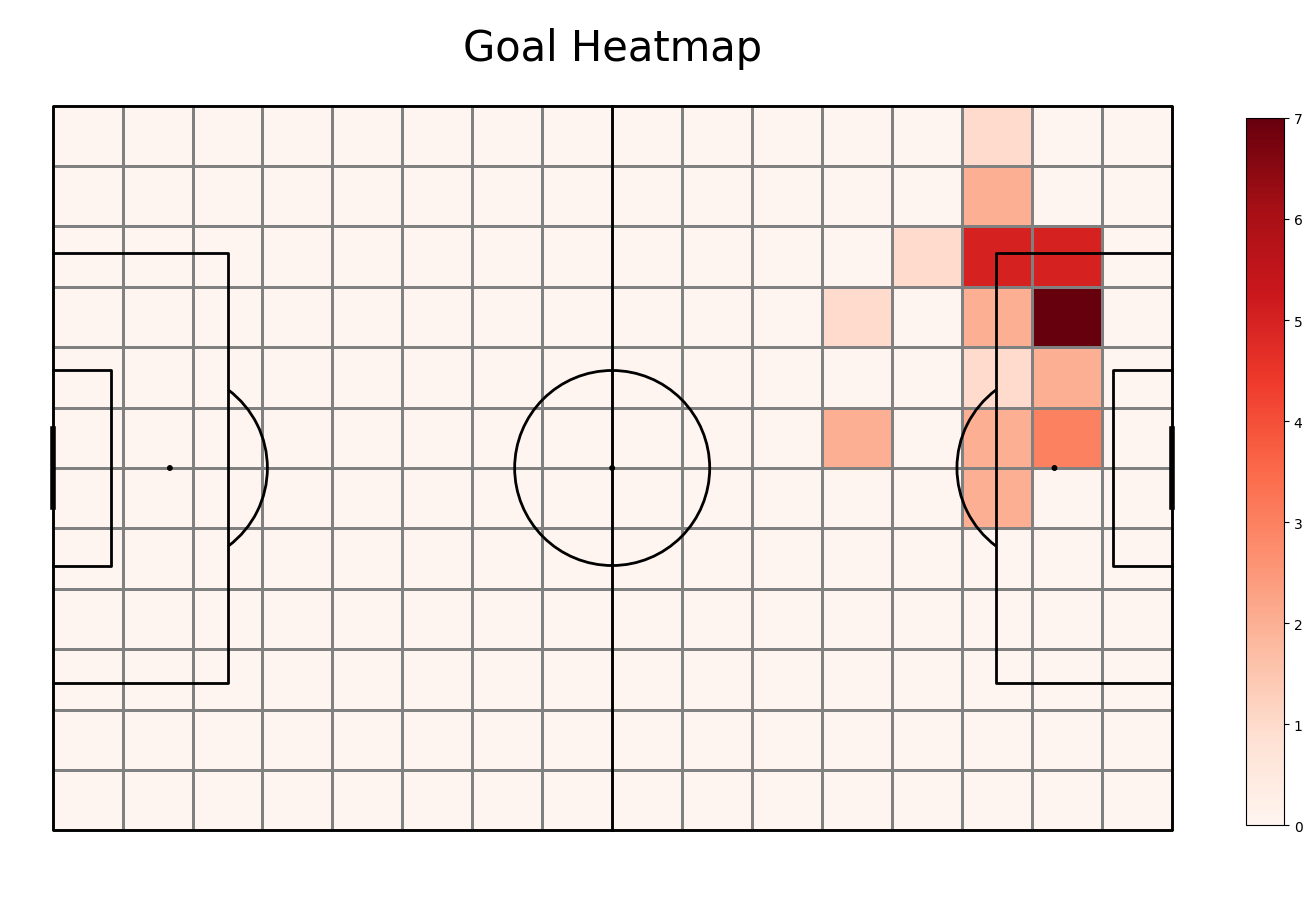

In [204]:
goal_df = shot_df.loc[shot_df['shot.isGoal'] == True]
goal = pitch.bin_statistic(goal_df["location.x"], goal_df["location.y"], statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal Heatmap', fontsize = 30)
plt.show()

### 8. Move Probability Heatmap

- After getting the cumulative counts per zone for moves, shots, and goals, the next step (according to the guide) is to convert them into probabilities.  
- First, I counted the total number of `actions` (move events + shot events).  
- Then, for the move part, I divided the move event count by the total.  
- Finally, I plotted the resulting probabilities on the pitch.  

> **Important Note:** While doing the calculations, I noticed that some zones on the field were never reached by any kind of pass. This produced `NaN` values, which would cause problems later. To avoid that, I replaced all potential `NaN` values with zeros so the data could be handled more reliably in the next steps.

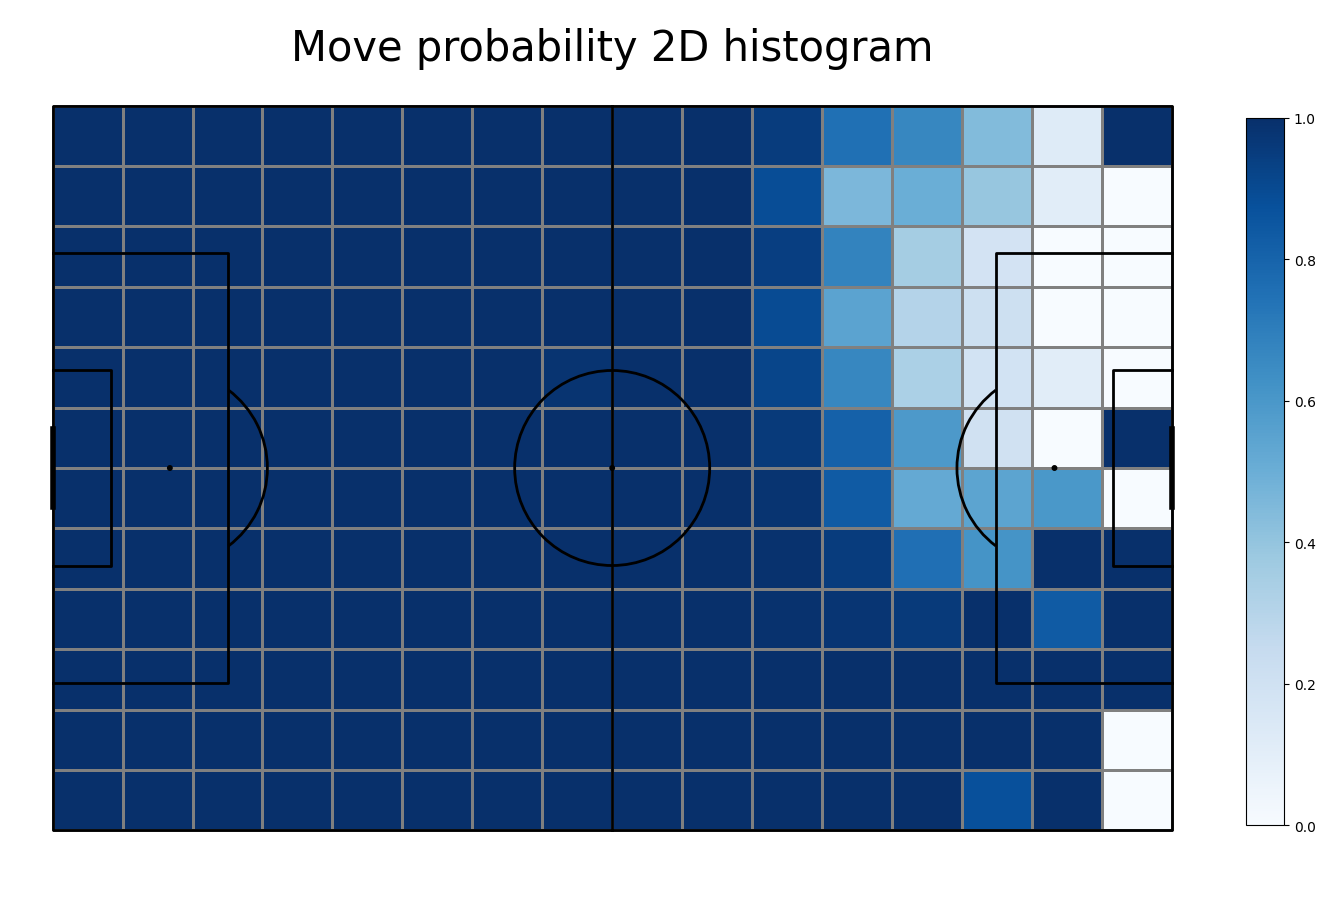

In [205]:

total_actions = move_count + shot_count
move_probability = np.nan_to_num(move_count / total_actions)


fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

### 9. Shot Probability Heatmap

- The methodology here is the same as in the previous step, applied to **shots** instead of moves.  
- The same observation about handling `NaN` values applies: any potential `NaN` outputs are converted to zeros to ensure smoother processing later.

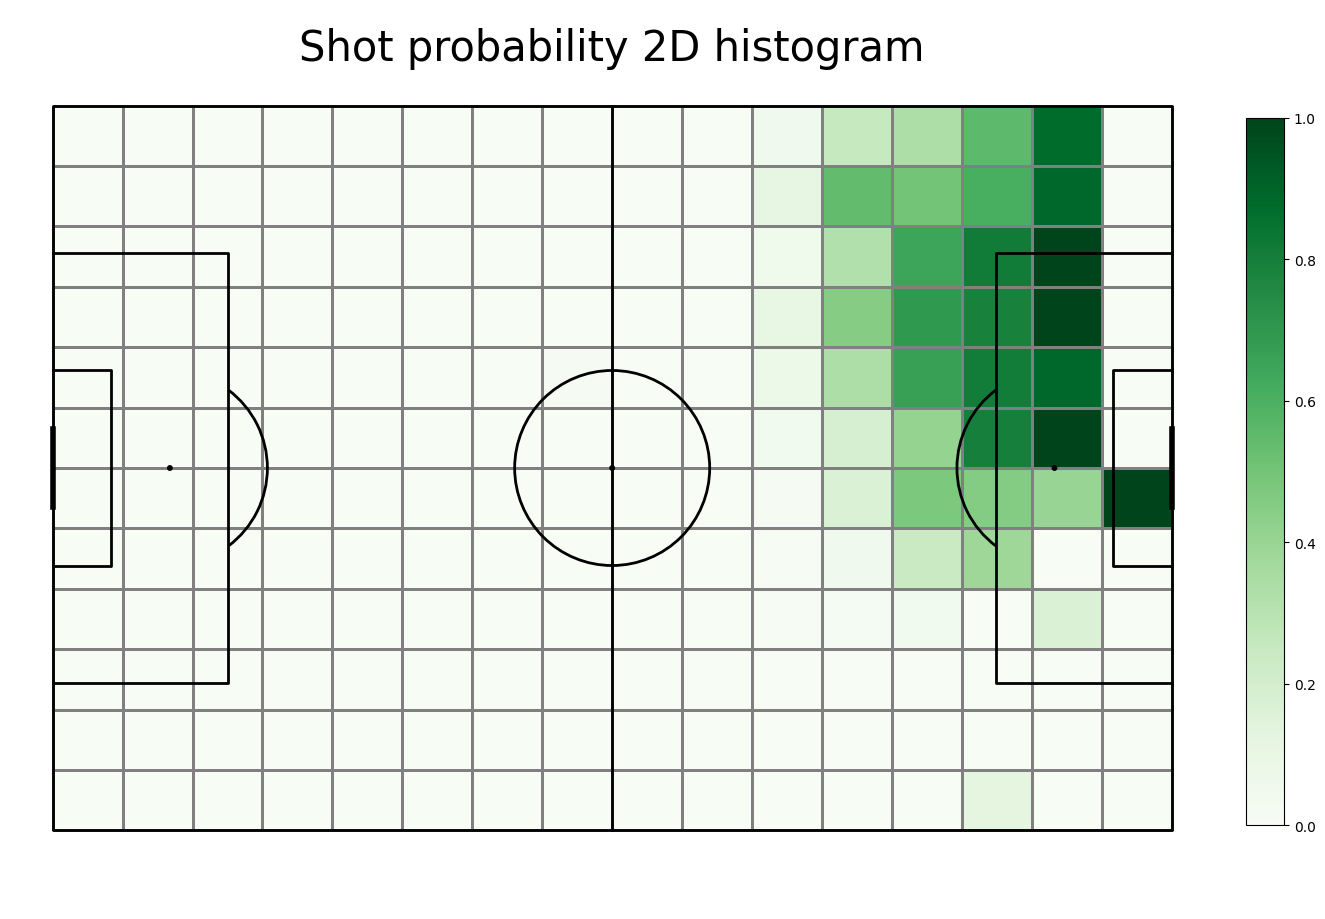

In [206]:
total_actions = move_count + shot_count
shot_probability = np.nan_to_num(shot_count / total_actions)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

### 10. Goal Probability Heatmap

- Don’t get frustrated and think: *“Wait, does goal probability mean xG?”*  
- The answer is: **not exactly… but also kind of yes.**  
- According to the Soccermatics guide, the calculation is straightforward: divide the number of goals by the number of shots in each zone. The result is what they call a *simplified expected goals model*, with a strong emphasis on **simplified**.  
- So to clarifyyy: this probability can be seen as a very rough version of xG, but without the sophistication of a full xG model.  

> **Note:** Same as before: if the output produces any `NaN` values, I make sure to convert them to zeros for easier handling later in the code.


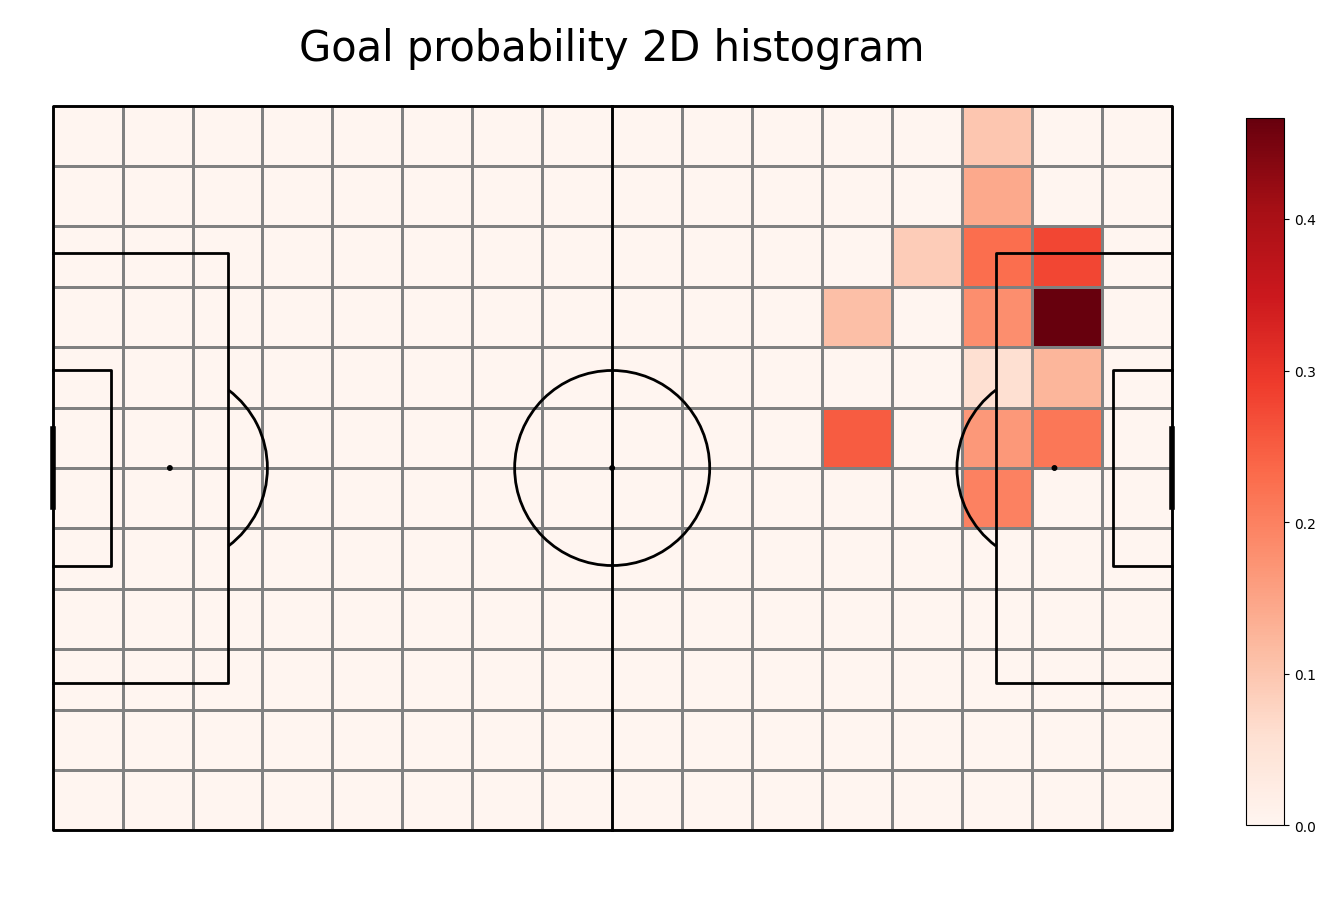

In [207]:
# The corrected calculation for goal probability
# This safely handles zones with zero shots, preventing NaN values.
goal_probability = np.divide(goal_count, shot_count, out=np.zeros_like(goal_count), where=shot_count != 0)

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

### 11. Transition Matrix

The transition matrix was one of the most interesting steps for me to implement.  
It’s basically like playing a *“what if?”* game with the ball. Instead of showing everything happening on the pitch, it focuses on just one question:

> *“If the ball starts in this zone, where is it most likely to end up next?”*

`How I Built It`

To create this matrix, I adapted the guide and made it fit my dataset:

- I started by assigning each action a **start sector** and an **end sector** by binning their `(x, y)` locations into a 16×12 grid on the pitch.  
- Then I added a filter to remove invalid sectors (cases where the binned coordinates fell outside the field).  
- After that, for each starting sector, I counted all the actions beginning there and checked where they ended.  
- Finally, I built a probability matrix: each cell shows how likely it is that the ball moves from a given **start zone** to a specific **end zone**.

> **Note:** To plot one of the 192 transition matrices, change this line:  
> `goal["statistic"] = transition_matrices[45]`  
> Replace `45` with any index from `0` to `191`. Keep in mind that some zones may have no movements at all (all zeros), which can break the plotting step. If that happens, either try another index or add a quick check in the code to skip empty sectors.



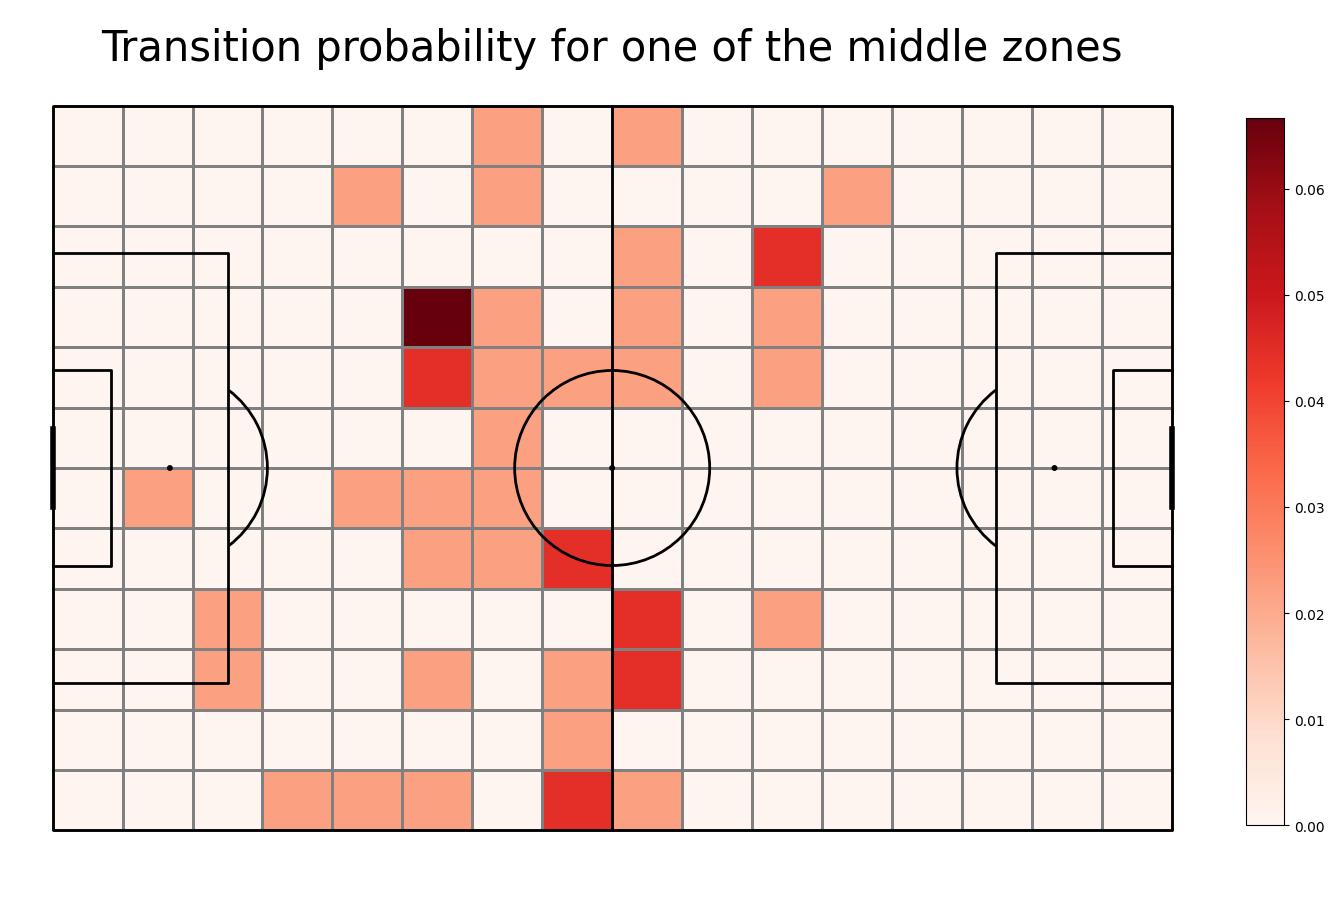

In [221]:

# Assuming your move_df and a pitch object are already created
# move start index
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row['location.x']), np.ravel(row['location.y']),
                                                                                          values="None", statistic="count",
                                                                                          bins=(16, 12), range=[[0, 105], [0, 68]],
                                                                                          expand_binnumbers=True)[3]]), axis=1)

# move end index
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row['pass.endLocation.x']), np.ravel(row['pass.endLocation.y']),
                                                                                        values="None", statistic="count",
                                                                                        bins=(16, 12), range=[[0, 105], [0, 68]],
                                                                                        expand_binnumbers=True)[3]]), axis=1)


move_df = move_df.loc[
    ((move_df["start_sector"].apply(lambda x: x[0] <= 16 and x[1] <= 12)) &
    (move_df["end_sector"].apply(lambda x: x[0] <= 16 and x[1] <= 12)))
]


df_count_starts = move_df.groupby(["start_sector"])["matchId"].count().reset_index()
df_count_starts.rename(columns = {'matchId':'count_starts'}, inplace=True)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    #get all events that started in this sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_count_ends = this_sector.groupby(["end_sector"])["matchId"].count().reset_index()
    df_count_ends.rename(columns = {'matchId':'count_ends'}, inplace=True)
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_count_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)


pitch = Pitch(line_color='black', pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
goal = pitch.bin_statistic(move_df['location.x'], move_df['location.y'], statistic='count', bins=(16, 12), normalize=False)


fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#Change the index here to change the zone.
goal["statistic"] = transition_matrices[80]
pcm = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()

### 12. xT Heatmap

The code I wrote below is the core of the whole project. It takes the guide’s approach to xT and adapts it to my dataset. The idea is to calculate the **Expected Threat (xT)** for every zone on the pitch — basically answering the question:  
*“How valuable is this zone in terms of leading to a goal?”*

`The Two Ingredients`

While going through the guide, I realized that the xT of a zone comes from two main parts:

- **Shot Payoff** → the chance of scoring directly from that zone (a one-and-done event).  
- **Move Payoff** → the chance of moving the ball into another, more dangerous zone.  

Together, they form the foundation of the xT calculation.

`How the Iteration Works`

The way the code does this is by looping through the pitch multiple times (`for i in range(10):` in my case).  
In each loop, every zone gets updated by asking two simple questions:

1. *“What’s the chance of scoring from here?”* → Shot Payoff  
2. *“What’s the chance of moving the ball to a better zone?”* → Move Payoff  

The two are then added together to update the xT value of that zone.  

`The Final Matrix`

This process repeats for all zones, loop after loop. With each iteration, zones closer to the goal gradually increase in value. After enough loops, the values stabilize, and that stable grid is the final **xT matrix**.  

For me, this was one of the most exciting parts to implement: it transforms raw event data into a complete **map of danger** — showing exactly which areas of the pitch hold the most threat against U Cluj.


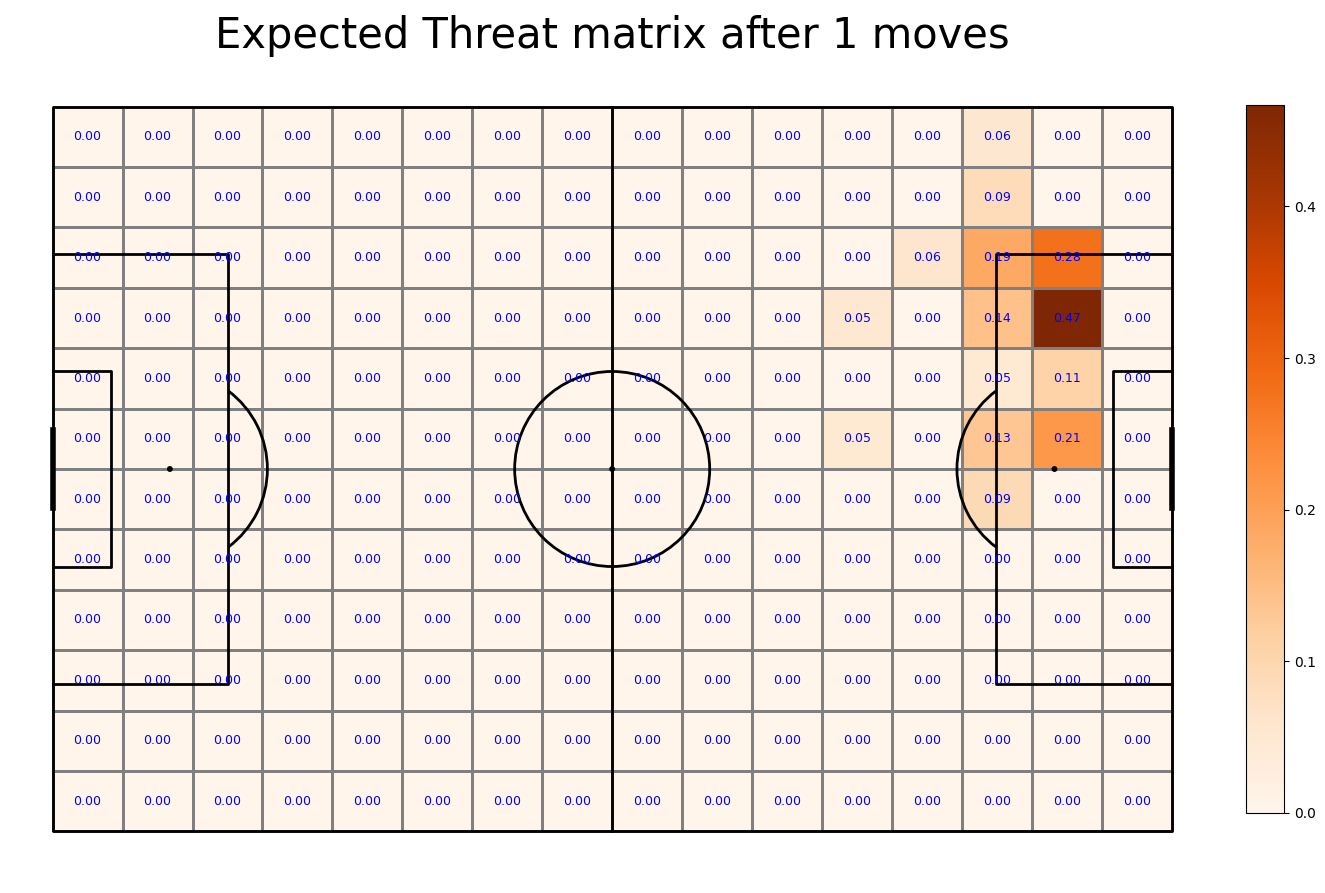

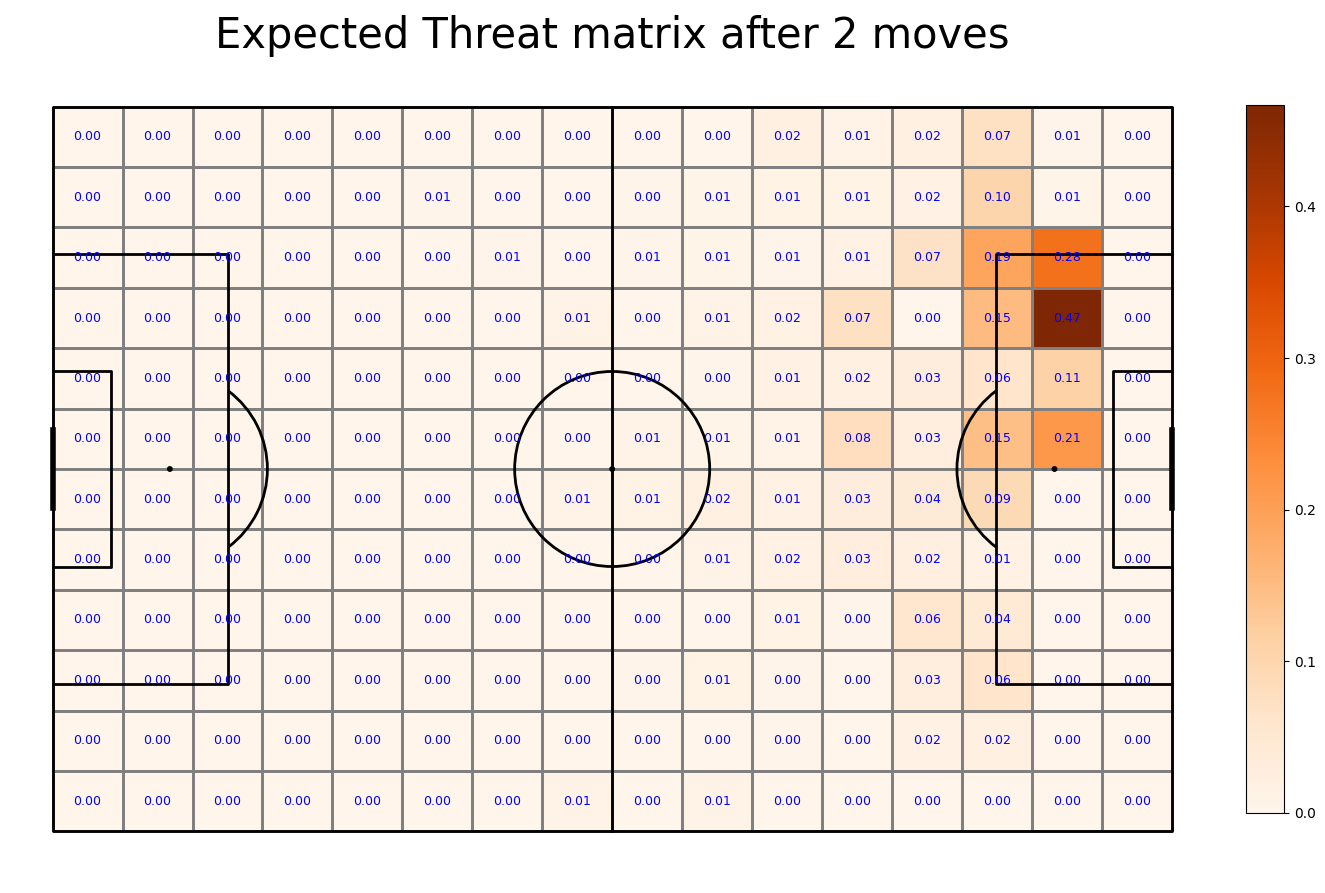

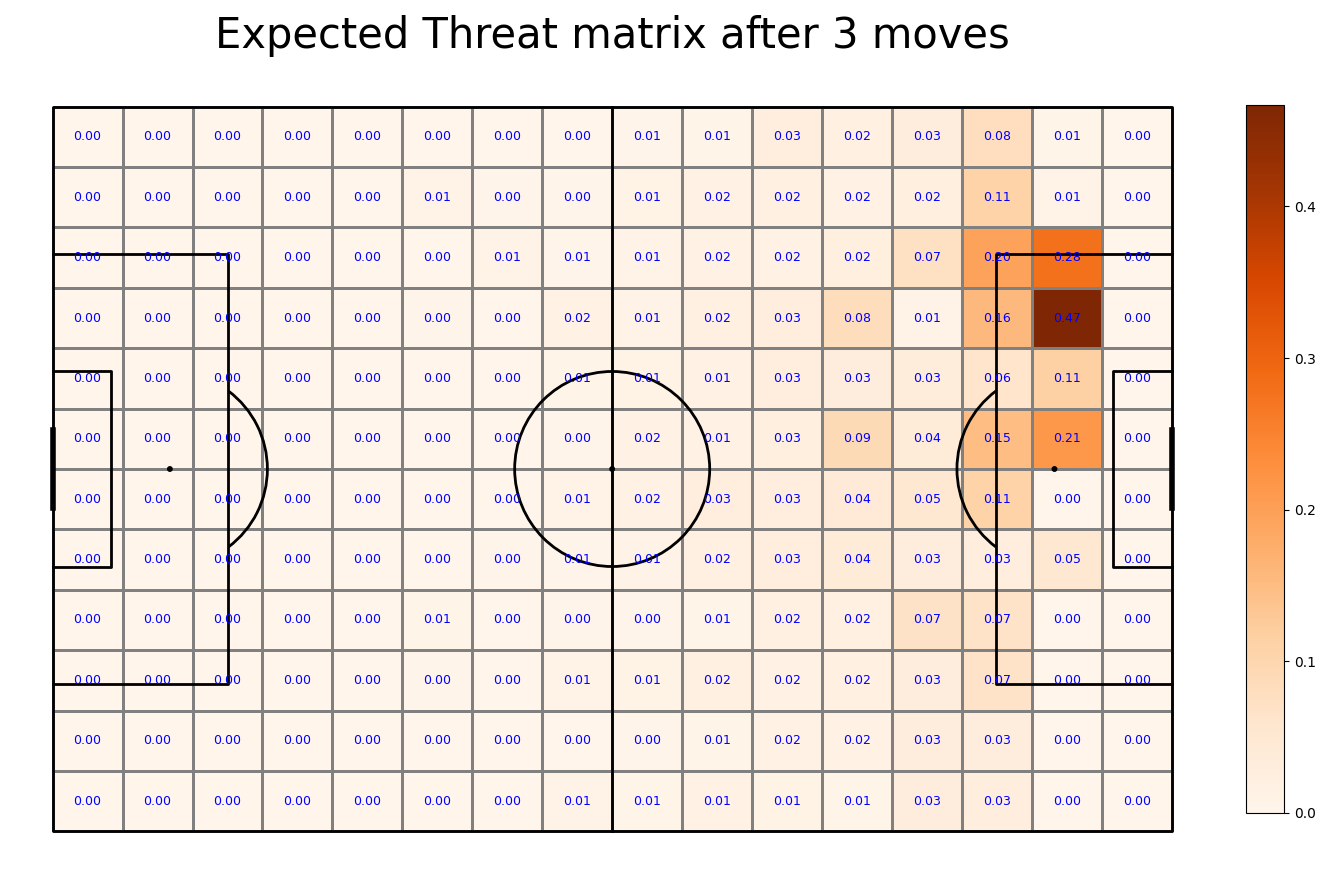

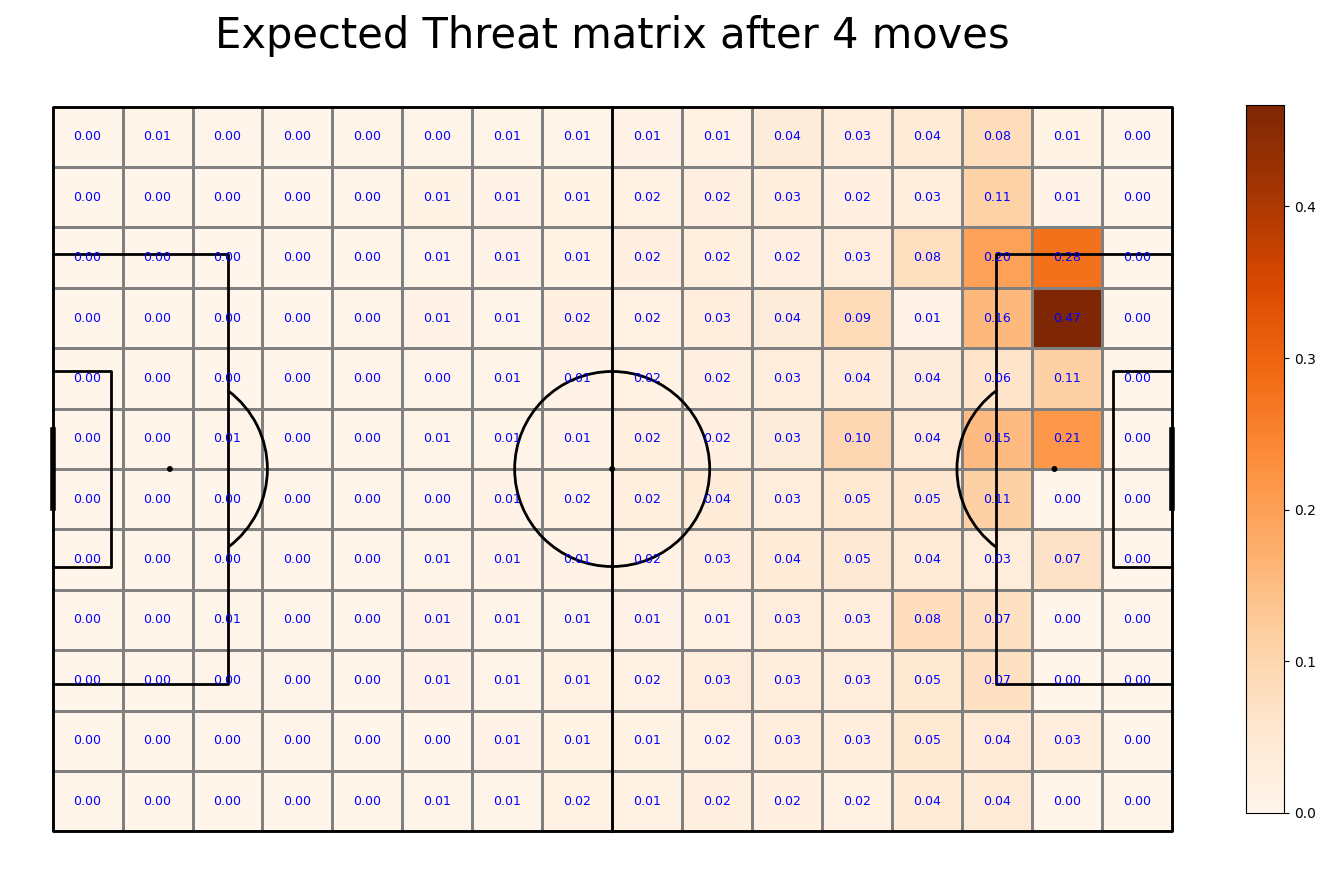

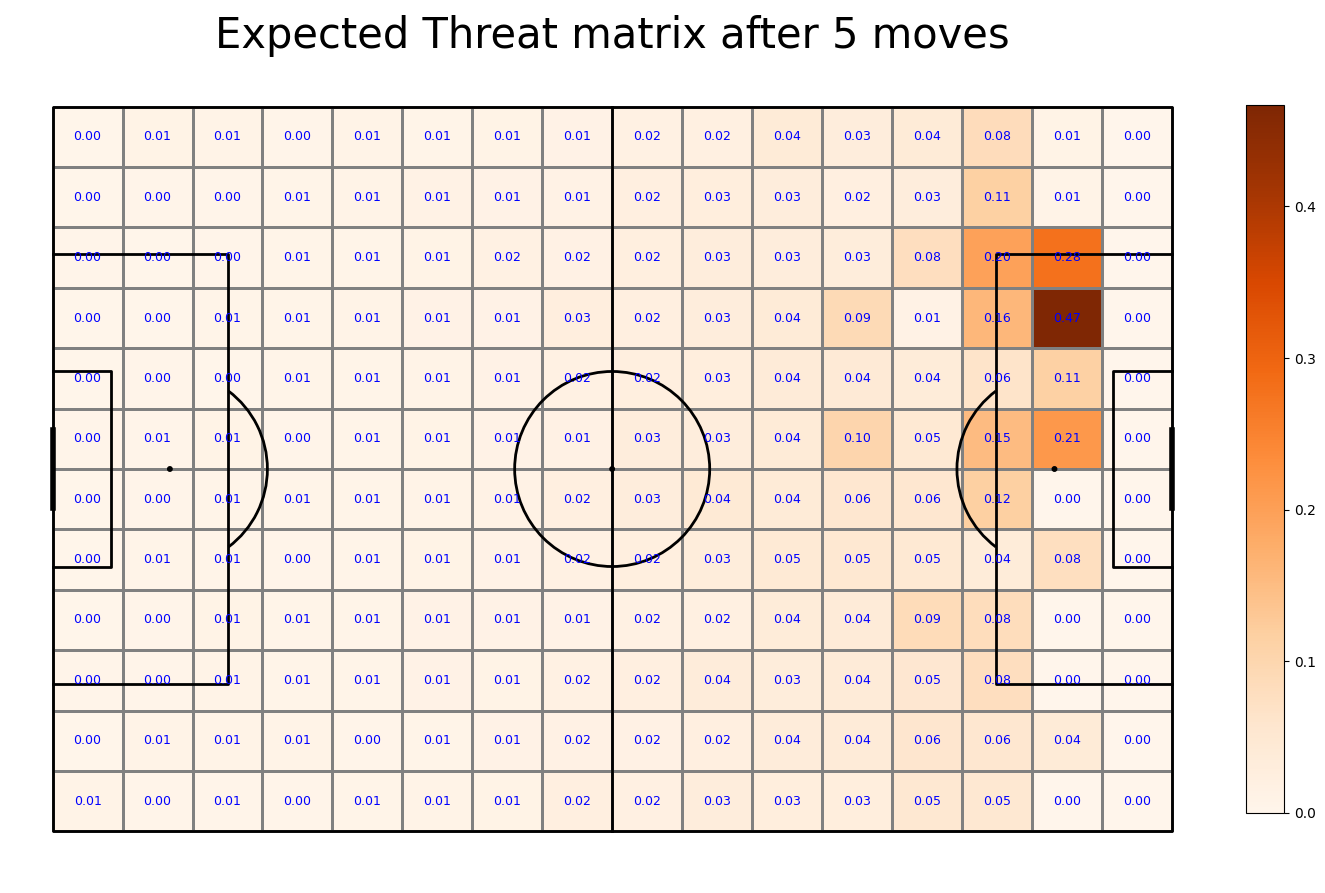

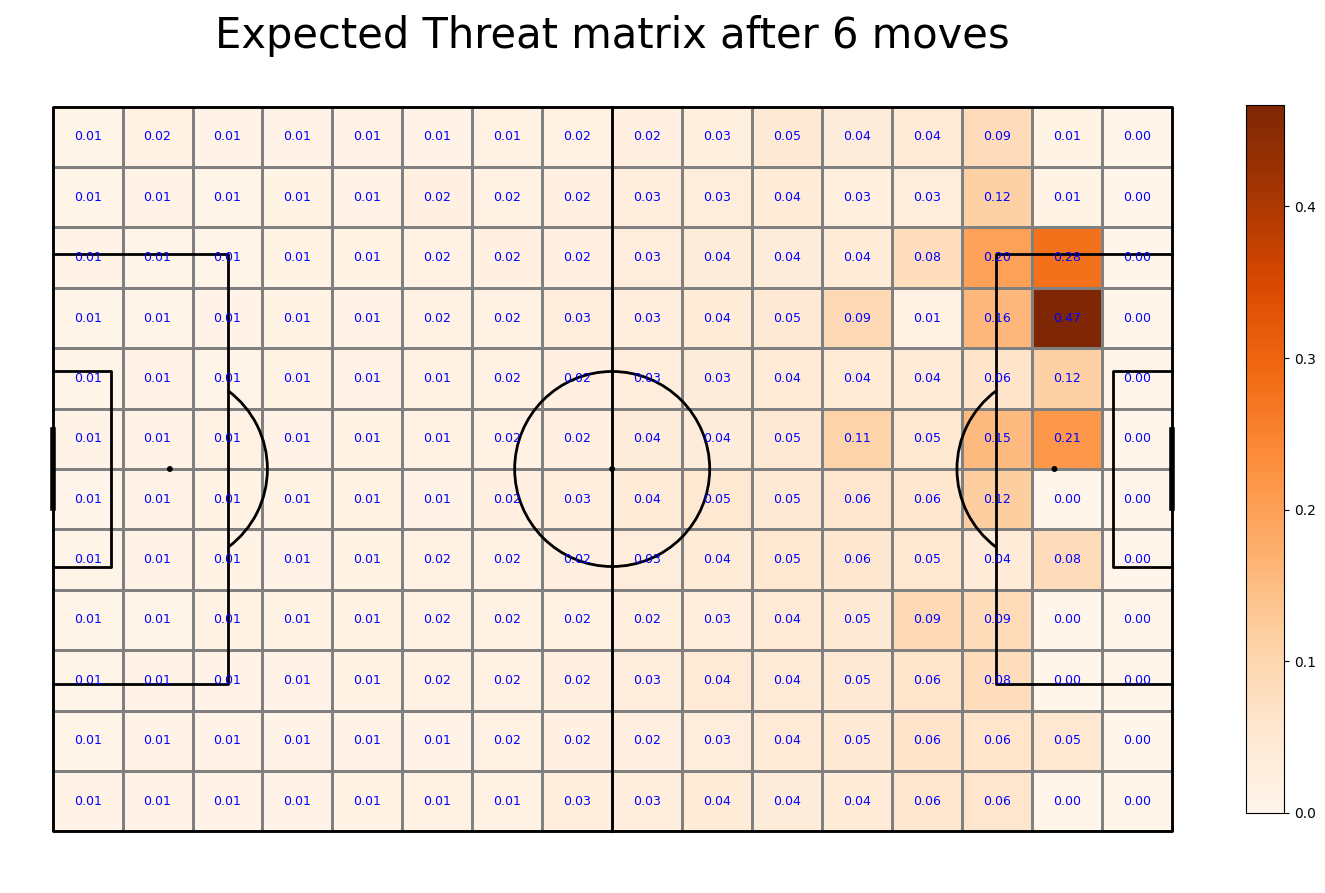

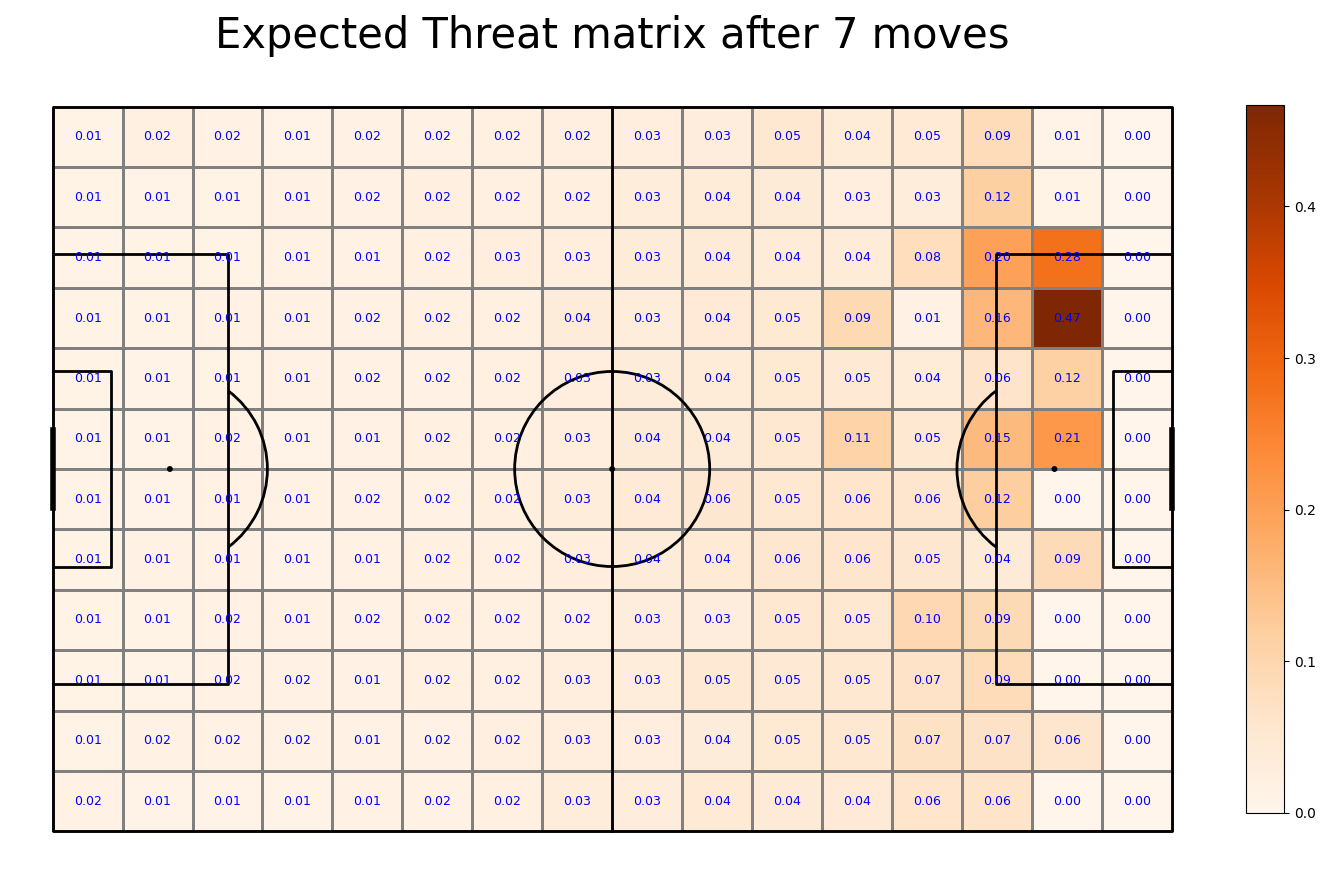

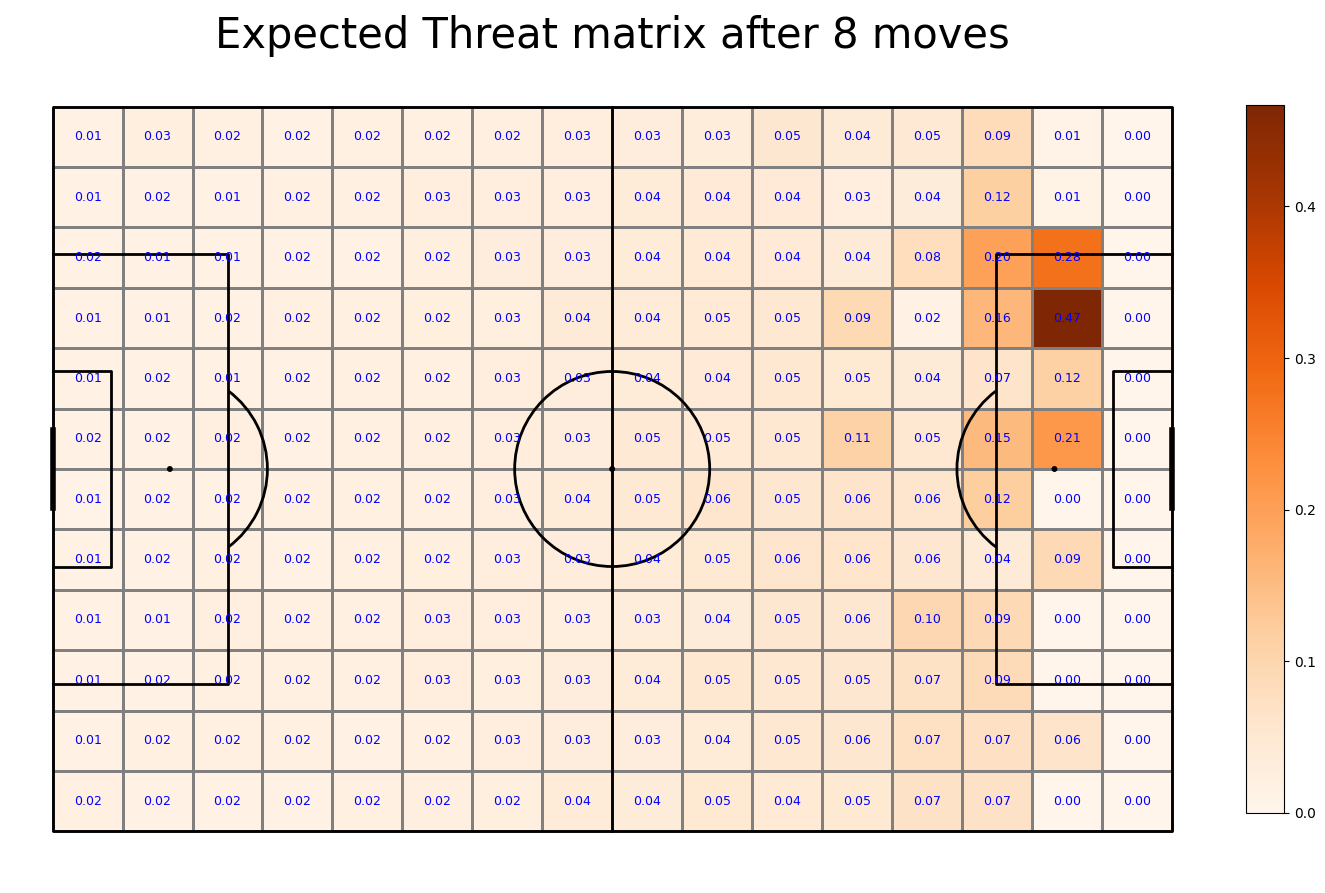

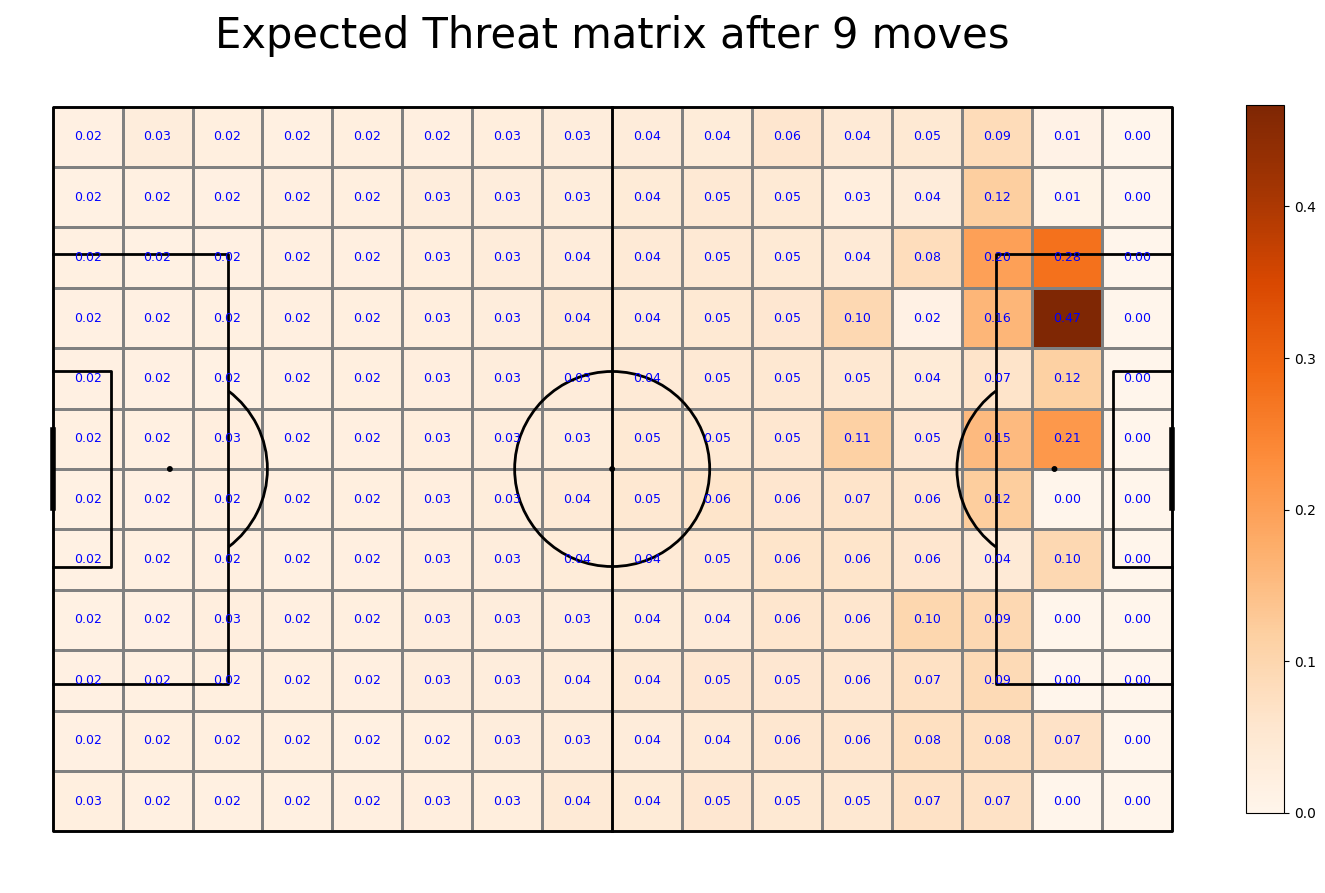

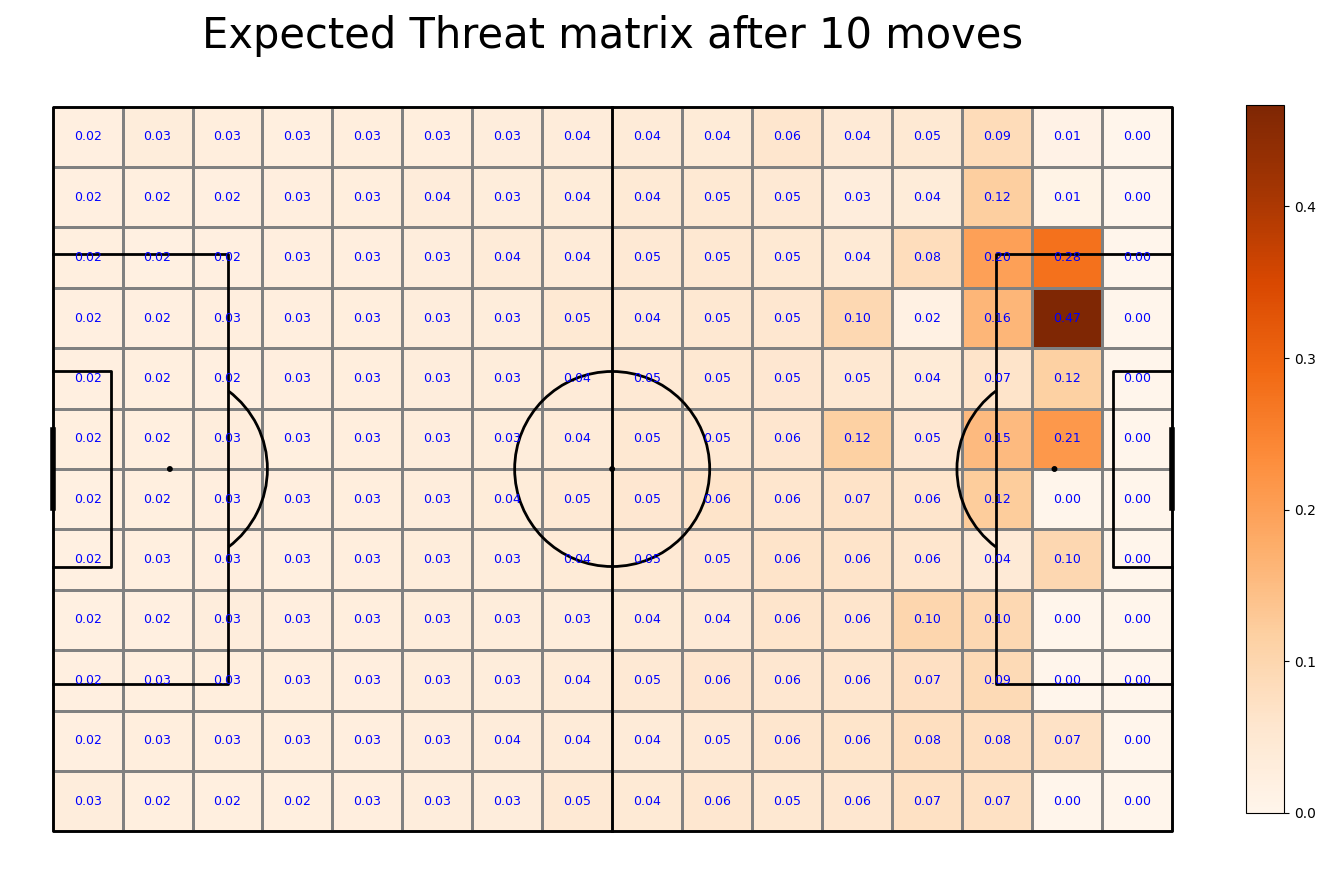

In [209]:

# Step 1: Create a dictionary for quick lookup
transition_matrices_dict = {
    row['start_sector']: transition_matrices[i]
    for i, row in df_count_starts.iterrows()
}

# Step 2: Create a full list of all 192 matrices
all_sectors = product(range(1, 17), range(1, 13))
transition_matrices_full = []
for sector in all_sectors:
    # If the sector is in our dictionary, use its matrix
    if sector in transition_matrices_dict:
        transition_matrices_full.append(transition_matrices_dict[sector])
    # If not, add a zero-filled matrix
    else:
        transition_matrices_full.append(np.zeros((12, 16)))

# Step 3: Convert the full list to a numpy array for calculation
transition_matrices_array = np.array(transition_matrices_full)
# The rest of your code from here is correct.
xT = np.zeros((12, 16))
for i in range(10):
    shoot_expected_payoff = goal_probability * shot_probability
    move_expected_payoff = move_probability * (np.sum(np.sum(transition_matrices_array * xT, axis=2), axis=1).reshape(16, 12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.01, title_space=0, endnote_space=0)

    # This assumes a 'goal' object for plotting. You may need to create it.
    goal = pitch.bin_statistic(move_df['location.x'], move_df['location.y'], statistic='count', bins=(16, 12), normalize=False)
    goal["statistic"] = xT

    pcm = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                                 ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder=3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' + str(i + 1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

## Applying xT value to moving actions

In [ ]:
# Assuming your 'move_df' and 'xT' matrix are already set up

# 1. Extract individual x and y sectors
# This will create new columns for the start and end x,y coordinates
move_df['start_sector_x'] = move_df['start_sector'].apply(lambda s: s[0] - 1)
move_df['start_sector_y'] = move_df['start_sector'].apply(lambda s: s[1] - 1)
move_df['end_sector_x'] = move_df['end_sector'].apply(lambda s: s[0] - 1)
move_df['end_sector_y'] = move_df['end_sector'].apply(lambda s: s[1] - 1)

# 2. Calculate xT added
# Now you can use the newly created columns to index the xT matrix
move_df["xT_added"] = move_df.apply(lambda row: xT[row.end_sector_y][row.end_sector_x] 
                                                  - xT[row.start_sector_y][row.start_sector_x], axis=1)

# 3. Filter for only progressive actions
value_adding_actions = move_df.loc[move_df["xT_added"] > 0].copy()

# Now, `value_adding_actions` contains the data we need
value_adding_actions.head(3)


,id,matchId,matchPeriod,minute,second,matchTimestamp,videoTimestamp,relatedEventId,type.primary,type.secondary,...,gameweek,points,Home_Away,start_sector,end_sector,start_sector_x,start_sector_y,end_sector_x,end_sector_y,xT_added
7,2555084388,5695562,1H,0,20,00:20.5,21.548375,2.555084e+09,pass,"[lateral_pass, short_or_medium_pass]",...,10,1,Home,"(2, 8)","(4, 3)",1,7,3,2,0.000833
10,2555084392,5695562,1H,0,27,00:27.5,28.462541,2.555084e+09,pass,[short_or_medium_pass],...,10,1,Home,"(3, 5)","(3, 2)",2,4,2,1,0.000796
11,2555084393,5695562,1H,0,29,00:29.7,30.722265,2.555084e+09,pass,"[forward_pass, long_pass, loss]",...,10,1,Home,"(3, 2)","(8, 1)",2,1,7,0,0.012292


## Finding out players with highest xT

In [211]:
# Step 1: Filter and group ONLY by player ID
xT_by_player = value_adding_actions.groupby("player.id")["xT_added"].sum().reset_index()

# Step 2: Correctly calculate the timestamp without considering halves
df['timestamp_in_seconds'] = (df['minute'] * 60) + df['second']

# Step 3: Calculate total minutes played per player using the new column
minutes_per_match = df.groupby(['matchId', 'player.id'])['timestamp_in_seconds'].agg(['min', 'max'])
minutes_per_match['minutes'] = (minutes_per_match['max'] - minutes_per_match['min']) / 60
total_minutes = minutes_per_match.groupby('player.id')['minutes'].sum().reset_index()

# Step 4: Calculate total games played per player
games_per_player = df.groupby('player.id')['matchId'].nunique().reset_index()
games_per_player.rename(columns={'matchId': 'games_played'}, inplace=True)

# Step 5: Create a player info lookup table with unique IDs
player_info = df[['player.id', 'player.name', 'team.name']].drop_duplicates()

# Step 6: Merge the xT, minutes, games played, and player info data
summary = xT_by_player.merge(total_minutes, how="left", on="player.id")
summary = summary.merge(games_per_player, how="left", on="player.id")
summary = summary.merge(player_info, how="left", on="player.id")
summary.rename(columns={'minutes': 'minutesPlayed'}, inplace=True)
summary = summary.fillna(0)

# Step 7: Filter for players who played at least one full game (90 minutes)
summary = summary.loc[summary["minutesPlayed"] > 90]

# Step 8: Calculate xT per 90 and sort
summary["xT_per_90"] = summary["xT_added"] * 90 / summary["minutesPlayed"]
summary.sort_values(by='xT_added', ascending=False, inplace=True)

summary.head()

,player.id,xT_added,minutesPlayed,games_played,player.name,team.name,xT_per_90
280,619740,1.894279,354.350000,4,C. Cîrjan,Dinamo Bucureşti,0.481121
171,412678,1.622647,197.833333,4,M. Korenica,CFR Cluj,0.738188
67,84970,1.600519,361.950000,4,A. Mitriță,Universitatea Craiova,0.397974
68,85276,1.498758,364.316667,4,N. Bancu,Universitatea Craiova,0.370250
214,503199,1.455961,273.900000,3,R. Opruț,Dinamo Bucureşti,0.478410
